In [ ]:
"""
==========================================
음향 기반 벽체 재질 분석 시스템
Acoustic Material Inference System
==========================================

[핵심 아이디어]
단순히 "울림이 있다/없다"가 아닌, "어떤 주파수가 살아남는가?"를 분석하여
벽체의 물리적 특성(가벽 vs 콘크리트)을 역추적합니다.

[주요 라이브러리]
- librosa: 오디오 신호 로딩 및 스펙트로그램 생성
- scipy.signal: 주파수 대역별 필터링 (Butterworth Band-pass Filter)
- scipy.stats: 선형 회귀를 통한 감쇠 기울기 계산
"""

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import stats, signal
import IPython.display as ipd


# ==========================================
# 1. 주파수 대역 분해 함수 (Spectral Decomposition)
# ==========================================
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Butterworth Band-pass Filter를 사용하여 특정 주파수 대역만 추출합니다.
    
    [물리적 의미]
    - 저주파(125~500Hz): 벽체의 두께와 밀도에 반응 (가벽일 경우 진동/공명 발생)
    - 고주파(1k~4kHz): 표면 재질에 반응 (유리/타일일 경우 강한 반사)
    
    [파라미터]
    - data: 입력 오디오 신호 (1D numpy array)
    - lowcut: 통과시킬 최저 주파수 (Hz)
    - highcut: 통과시킬 최고 주파수 (Hz)
    - fs: 샘플링 레이트 (Hz)
    - order: 필터 차수 (기본값 5, 높을수록 더 날카로운 필터링)
    
    [반환값]
    - y: 필터링된 신호 (위상 왜곡 없는 양방향 필터링 결과)
    """
    # 나이퀴스트 주파수 계산: 샘플링 레이트의 절반
    # (샘플링 이론에 따라 fs/2 이상의 주파수는 재현 불가능)
    # 원본이 4 Hz인데 샘플링이 2Hz라면 파형을 재현할 수 없다.
    nyq = 0.5 * fs
    
    # 정규화된 주파수로 변환 (0~1 사이의 값)
    # 예: 125Hz / (22050Hz/2) = 0.0057
    low = lowcut / nyq
    high = highcut / nyq
    
    # Butterworth 필터 계수 계산
    # btype='band': 대역 통과 필터 (band-pass filter)
    b, a = signal.butter(order, [low, high], btype='band')
    
    # 양방향 필터링 (filtfilt): 위상 왜곡 없이 필터링
    # 한 방향으로 필터링하면 위상이 지연되므로, 역방향으로도 한 번 더 필터링하여 보정
    y = signal.filtfilt(b, a, data)
    
    return y


# ==========================================
# 2. 슈뢰더 적분 & RT60 계산 함수
# (Schroeder Integration & T20 Decay Analysis)
# ==========================================
def get_decay_curve_and_rt60(y, sr):
    """
    슈뢰더 역방향 적분을 통해 에너지 감쇠 곡선을 추출하고, RT60을 계산합니다.
    
    [알고리즘 단계]
    1. 피크 지점 찾기: 임펄스 사운드(박수)의 최대 진폭 지점
    2. 에너지 계산: 진폭의 제곱 (에너지는 진폭의 제곱에 비례)
    3. 슈뢰더 적분: 역방향 누적합으로 매끄러운 감쇠 곡선 생성
    4. dB 변환: 로그 스케일로 변환하여 인간의 청각 특성에 맞춤
    5. 선형 구간 추출: -5dB ~ -25dB 구간 (생활 소음의 영향을 최소화)
    6. 선형 회귀: 기울기를 통해 RT60 추정
    
    [파라미터]
    - y: 입력 오디오 신호 (1D numpy array)
    - sr: 샘플링 레이트 (Hz)
    
    [반환값]
    - rt60: 잔향 시간 (초) - 소리가 60dB 감쇠하는데 걸리는 시간
    - y_slice: 분석에 사용된 감쇠 곡선 구간 (시각화용)
    """
    # Step 1: 피크 지점 찾기
    # 임펄스 사운드(박수)의 최대 진폭이 발생한 시점을 찾습니다
    peak_index = np.argmax(np.abs(y))
    
    # 피크 이후의 신호만 사용 (피크 이전은 무시)
    y = y[peak_index:]
    
    # Step 2: 에너지 계산
    # 에너지는 진폭의 제곱에 비례합니다 (E ∝ A²)
    energy = y ** 2
    
    # Step 3: 슈뢰더 역방향 적분 (Schroeder Backward Integration)
    # 역방향으로 누적합을 계산하여 매끄러운 감쇠 곡선을 생성합니다
    # 이는 노이즈를 평활화하고 선형적인 감쇠 패턴을 강조합니다
    s_energy = np.flip(np.cumsum(np.flip(energy)))
    
    # Step 4: dB 변환 (데시벨 스케일)
    # 로그 스케일로 변환하여 인간의 청각 특성에 맞춥니다
    # epsilon: 0으로 나누는 것을 방지하기 위한 작은 값
    epsilon = 1e-10
    s_db = 10 * np.log10(s_energy / np.max(s_energy) + epsilon)
    
    # Step 5: 선형 구간 추출 (-5dB ~ -25dB)
    # 이 구간은 생활 소음(Noise Floor)의 영향을 최소화하면서
    # 가장 선형적인 감쇠를 보이는 구간입니다
    idx_start = np.where(s_db <= -5)[0]  # -5dB 이하로 떨어진 첫 지점
    idx_end = np.where(s_db <= -25)[0]   # -25dB 이하로 떨어진 첫 지점
    
    # 예외 처리: 유효한 구간이 없으면 기본값 반환
    if len(idx_start) == 0 or len(idx_end) == 0:
        return 0.1, s_db 
    
    idx_start = idx_start[0]
    idx_end = idx_end[0]
    
    # 예외 처리: 시작점이 끝점보다 뒤에 있으면 기본값 반환
    if idx_start >= idx_end:
        return 0.1, s_db
    
    # Step 6: 선형 회귀 분석
    # 추출된 구간의 시간 인덱스와 dB 값을 사용하여 기울기를 계산합니다
    x = np.arange(idx_start, idx_end)  # 시간 인덱스
    y_slice = s_db[idx_start:idx_end]  # 해당 구간의 dB 값
    
    # scipy.stats.linregress: 최소제곱법을 사용한 선형 회귀
    # slope: 기울기 (dB/샘플 단위, 보통 음수)
    slope, _, _, _, _ = stats.linregress(x, y_slice)
    
    # 예외 처리: 기울기가 0이면 작은 음수값으로 대체
    if slope == 0: 
        slope = -0.001
    
    # Step 7: RT60 계산
    # RT60 = -60dB / (기울기 * 샘플링 레이트)
    # 기울기가 음수이므로 -60을 나누면 양수가 됩니다
    rt60 = -60 / slope / sr
    
    # 분석에 사용된 구간만 반환 (시각화를 위해)
    return abs(rt60), y_slice


# ==========================================
# 3. 벽체 재질 분석 메인 함수
# (Acoustic Material Inference)
# ==========================================
def analyze_wall_material(file_path):
    """
    오디오 파일을 분석하여 벽체 재질을 추론합니다.
    
    [핵심 알고리즘: Bass Ratio 기반 판별]
    Bass Ratio = RT60_Low / RT60_High
    
    판별 로직:
    - Bass Ratio > 1.25: 가벽/중공벽 (저음이 오래 남음 → 공명 발생)
    - 0.8 ≤ Bass Ratio ≤ 1.25: 콘크리트/조적벽 (균형 잡힌 감쇠)
    - Bass Ratio < 0.8: 반사성 표면 (고음이 오래 남음 → 유리/타일)
    
    [파라미터]
    - file_path: 분석할 오디오 파일 경로 (.wav 파일)
    
    [반환값]
    - bass_ratio: 저주파/고주파 RT60 비율
    """
    print(f"Sound Loading... : {file_path}")
    
    # Step 1: 오디오 파일 로딩
    # librosa.load: 다양한 샘플링 레이트를 자동으로 처리
    # sr=None: 원본 샘플링 레이트 유지
    try:
        y, sr = librosa.load(file_path, sr=None)
    except FileNotFoundError:
        print("❌ 파일을 찾을 수 없습니다.")
        return
    
    # Step 2: 주파수 대역 분해 (Spectral Decomposition)
    # 문제: 일반적인 RT60 측정은 모든 주파수를 뭉뚱그려 계산하므로,
    #       벽이 얇아서 울리는 건지(공명), 단순히 방이 비어서 울리는 건지(반사) 구별 불가
    # 해결: 입력된 임펄스 사운드를 두 개의 핵심 대역으로 분리
    
    # 🔴 Low Band (125~500Hz): 벽체의 두께와 밀도에 반응
    #    가벽일 경우 진동/공명이 발생하여 저음이 오래 남음
    y_low = butter_bandpass_filter(y, 125, 500, sr, order=5)
    
    # 🔵 High Band (1k~4kHz): 표면 재질에 반응
    #    유리/타일일 경우 강한 반사로 고음이 오래 남음
    y_high = butter_bandpass_filter(y, 1000, 4000, sr, order=5)
    
    # Step 3: 대역별 RT60 및 감쇠 곡선 계산
    # 각 주파수 대역에 대해 슈뢰더 적분을 수행하여 RT60을 계산합니다
    # 참고: 저음과 고음은 피크 위치가 달라서 curve의 길이가 서로 다를 수 있습니다
    rt60_full, curve_full = get_decay_curve_and_rt60(y, sr)      # 전체 대역
    rt60_low, curve_low = get_decay_curve_and_rt60(y_low, sr)    # 저주파 대역
    rt60_high, curve_high = get_decay_curve_and_rt60(y_high, sr) # 고주파 대역
    
    # Step 4: Bass Ratio 계산
    # 핵심 지표: 저주파 RT60 / 고주파 RT60
    # 이 비율이 벽체의 물리적 특성을 나타냅니다
    # 1e-5: 0으로 나누는 것을 방지하기 위한 작은 값
    bass_ratio = rt60_low / (rt60_high + 1e-5)
    
    # Step 5: 벽체 재질 판별 (Material Classification)
    wall_type = "판단 보류"
    
    # 전체 RT60이 매우 짧으면 흡음이 잘 되는 환경 (안전)
    if rt60_full < 0.3:
        wall_type = "🔕 흡음 환경 (Safe)"
    
    # Bass Ratio > 1.25: 가벽/중공벽 의심
    # 고음은 금방 사라지는데 저음이 웅웅거리며 오래 남는 현상
    # 벽체 내부가 비어있어(Hollow) 저주파 공진이 발생함을 의미 → 방음 취약
    elif bass_ratio > 1.25:
        wall_type = "⚠️ 가벽/중공벽 의심 (Warning)"
    
    # 0.8 ≤ Bass Ratio ≤ 1.25: 콘크리트/조적벽
    # 저음과 고음이 균형 있게 감소함
    # 벽체가 꽉 차 있고 밀도가 높음을 의미 → 구조적 양호
    elif 0.8 <= bass_ratio <= 1.25:
        wall_type = "✅ 콘크리트/조적벽 (Normal)"
    
    # Bass Ratio < 0.8: 반사성 표면
    # 고음이 유난히 쨍하게 남음
    # 유리창이나 타일 마감이 주된 환경
    else:
        wall_type = "💎 반사성 표면 (Glass/Tile)"
    
    # ==========================================
    # Step 6: 시각화 (Visualization)
    # ==========================================
    plt.figure(figsize=(14, 10))
    
    # 6-1. 스펙트로그램 (Spectrogram)
    # 시간에 따른 주파수 분포를 시각화
    # librosa.stft: 단시간 푸리에 변환 (Short-Time Fourier Transform)
    # 소리의 파형을 주파수 도메인으로 변환하여 스펙트로그램 생성
    plt.subplot(2, 2, 1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("1. Spectrogram (주파수-시간 분포도)")
    
    # 6-2. 파형 (Waveform)
    # 시간에 따른 진폭 변화를 시각화
    plt.subplot(2, 2, 2)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title("2. Waveform (시간-진폭 파형)")
    
    # 6-3. 감쇠 곡선 비교 (Spectral Decay Analysis)
    # 핵심 시각화: 저주파(빨강) vs 고주파(파랑) 감쇠 패턴 비교
    # 이 그래프를 통해 Bass Ratio의 의미를 직관적으로 이해할 수 있습니다
    plt.subplot(2, 1, 2)
    
    # X축(시간)을 데이터 길이에 맞춰서 생성
    # 각 곡선의 길이가 다를 수 있으므로 개별적으로 시간축 생성
    plt.plot(np.arange(len(curve_full))/sr, curve_full, 'k--', alpha=0.3, 
             label=f'Full Band ({rt60_full:.2f}s)', linewidth=1)
    plt.plot(np.arange(len(curve_low))/sr, curve_low, 'r', linewidth=2.5, 
             label=f'Low Band 125-500Hz ({rt60_low:.2f}s)')
    plt.plot(np.arange(len(curve_high))/sr, curve_high, 'b', linewidth=1.5, 
             label=f'High Band 1k-4kHz ({rt60_high:.2f}s)')
    
    plt.title("3. Spectral Decay Analysis (저주파 vs 고주파 감쇠 비교)")
    plt.xlabel("Time (초)")
    plt.ylabel("Energy (dB)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    # 결과 텍스트 박스
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
    textstr = f'Bass Ratio: {bass_ratio:.2f}\nType: {wall_type}'
    plt.text(0.02, 0.1, textstr, transform=plt.gca().transAxes, fontsize=12, bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Step 7: 결과 출력
    print("-" * 50) 
    print(f"📢 분석 결과: {wall_type}")
    print(f"📊 Bass Ratio: {bass_ratio:.2f}")
    print(f"   - 저주파 RT60: {rt60_low:.2f}초")
    print(f"   - 고주파 RT60: {rt60_high:.2f}초")
    print(f"   - 전체 RT60: {rt60_full:.2f}초")
    print("-" * 50)
    
    return bass_ratio

Sound Loading... : test_bad_room.wav


/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipykernel_64712/1859053446.py:281: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipykernel_64712/1859053446.py:281: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipykernel_64712/1859053446.py:281: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipykernel_64712/1859053446.py:281: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipykernel_64712/1859053446.py:281: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/x657zs2d2njbhg_4j5qvkn5c0000gn/T/ipy

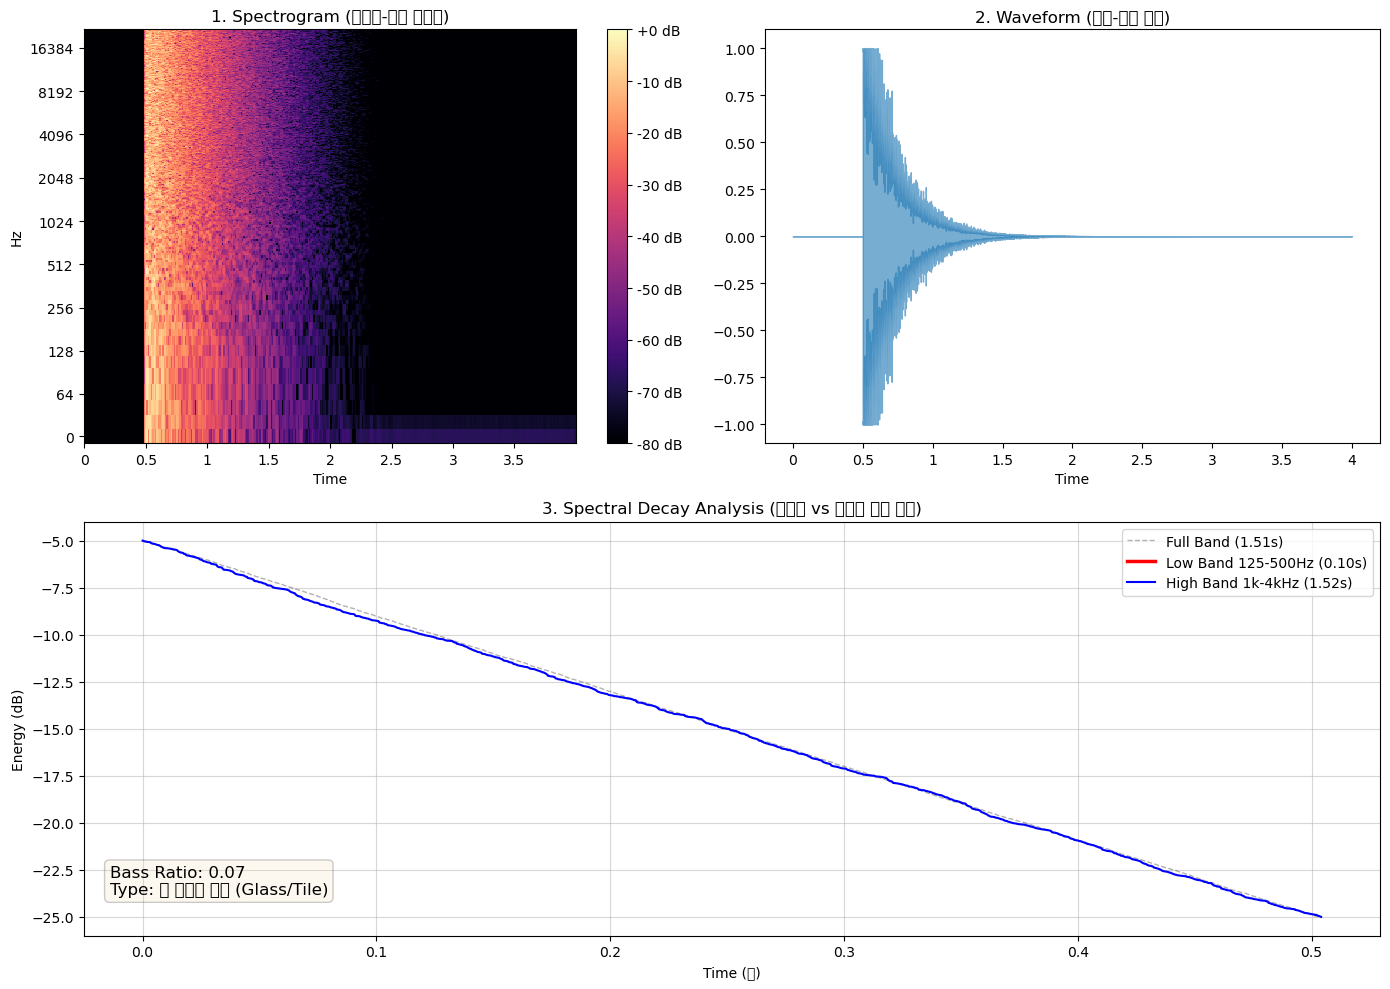

--------------------------------------------------
📢 분석 결과: 💎 반사성 표면 (Glass/Tile)
📊 Bass Ratio: 0.07
   - 저주파 RT60: 0.10초
   - 고주파 RT60: 1.52초
   - 전체 RT60: 1.51초
--------------------------------------------------
🎧 오디오 재생:


In [18]:
# ==========================================
# 사용 예시: 벽체 재질 분석 실행
# ==========================================

# 분석할 오디오 파일 경로 지정
# 주의: 파일은 박수 소리(임펄스 사운드)가 녹음된 .wav 파일이어야 합니다
file_path = "test_normal_room.wav" 

# 벽체 재질 분석 실행
# 결과: 그래프 3개 (스펙트로그램, 파형, 감쇠 곡선) 및 판별 결과 출력
analyze_wall_material("test_bad_room.wav")

# (선택사항) 원본 오디오 재생
# 분석한 오디오를 직접 들어보며 결과를 확인할 수 있습니다
print("🎧 오디오 재생:")
ipd.Audio("test_bad_room.wav")